<h1>Importing the Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']


In [2]:

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

import json
import warnings
warnings.filterwarnings('ignore')
import base64
import io
from scipy.misc import imread
import codecs
from IPython.display import HTML

<h1>Reading Input

In [3]:
movies=pd.read_csv('../input/tmdb_5000_movies.csv')
mov=pd.read_csv('../input/tmdb_5000_credits.csv')

<h1>Converting JSON entries to list

In [4]:
def from_json(df,attr):
    df[attr] = df[attr].apply(json.loads)
    
    for index,i in zip(df.index, df[attr]):
        l=[]
        for j in range(len(i)):
            l.append(i[j]['name'])
        df.loc[index,attr] = str(l)
    

In [5]:
json_columns = ['keywords','production_companies','production_countries','spoken_languages']

In [6]:
for c in json_columns:
    from_json(movies,c)

In [7]:
from_json(mov,'cast')

<h1>Selecting only Director from Crew

In [8]:

def director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    else:
        return "Unknown"


In [9]:
mov['crew']=mov['crew'].apply(json.loads)
mov['crew']=mov['crew'].apply(director)
mov.rename(columns={'crew':'director'},inplace=True)

<h1>Creating a Single DataFrame from the two

In [10]:
movies = movies.merge(mov, left_on='id', right_on='movie_id',how='left')

In [13]:
movies.columns

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'movie_id', 'title_y', 'cast', 'director'],
      dtype='object')

In [85]:
movies.head(1)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,movie_id,title_y,cast,director,PoL
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"['culture clash', 'future', 'space war', 'spac...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"['Ingenious Film Partners', 'Twentieth Century...","['United States of America', 'United Kingdom']",2009-12-10,2787965087,162.0,"['English', 'Español']",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",James Cameron,2550965087


<h1>Adding New Column: Profit/Loss

In [222]:
movies['PoL']=movies.revenue - movies.budget

In [14]:
df=movies[['id','original_title','genres','cast','vote_average','vote_count','popularity','director','keywords','runtime','budget','revenue','PoL']]


In [15]:
df.head(2)

,id,original_title,genres,cast,vote_average,vote_count,popularity,director,keywords,runtime
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","['Sam Worthington', 'Zoe Saldana', 'Sigourney ...",7.2,11800,150.437577,James Cameron,"['culture clash', 'future', 'space war', 'spac...",162.0
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","['Johnny Depp', 'Orlando Bloom', 'Keira Knight...",6.9,4500,139.082615,Gore Verbinski,"['ocean', 'drug abuse', 'exotic island', 'east...",169.0


<h1>Bubble Plot of Top 30 Movies by Vote_Average,Vote_count,Popularity and Profit/Loss

In [45]:
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go



In [54]:
df = movies.sort_values(by='budget',ascending=False).iloc[:20,:]

In [83]:
df = df[df.vote_count>1000].iloc[:30,:]
df = df.sort_values(by='vote_average',ascending=False)

In [84]:
data = [
    {
        'y': df.vote_average,
        'x': df.original_title,
        'mode': 'markers',
        'marker': {
            'color': df.popularity,
            'size': df.vote_count//100,
            'showscale': True
        },
        "text" :df.PoL//1000000
    }
]
iplot(data)

<h1>WordCloud of Keywords

In [86]:
from wordcloud import WordCloud

In [ ]:
kw = movies['keywords'].values.tolist()

In [91]:
kw = [eval(x) for x in kw]

In [93]:
kw = sum(kw,[])

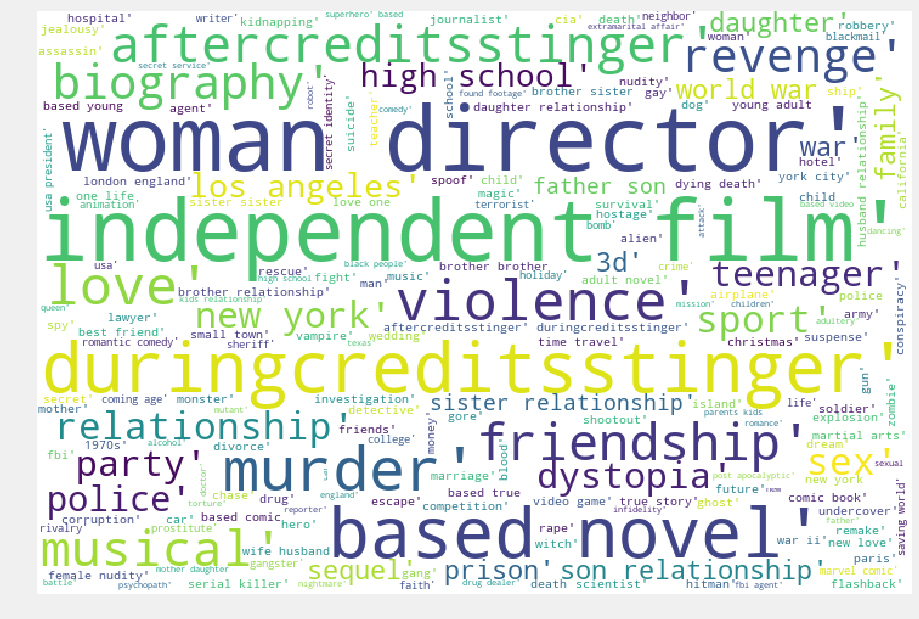

In [94]:
plt.subplots(figsize=(20,10))
wordcloud = WordCloud(
                          background_color='white',
                          width=720,
                          height=480
                         ).generate(" ".join(kw))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('graph.png')

plt.show()

<h1>WordCloud Tagline

In [108]:

movies.tagline.isnull().sum()

844

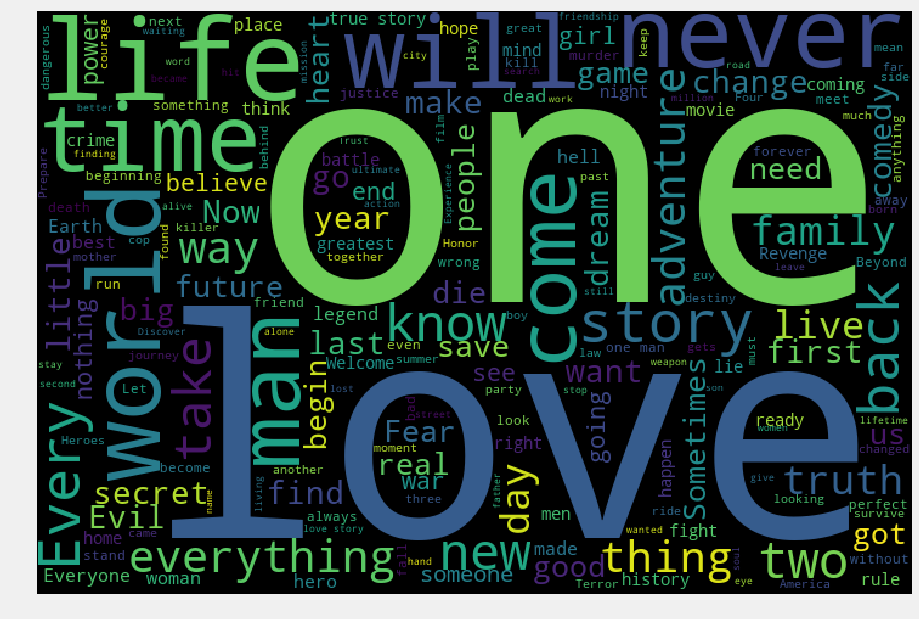

In [109]:

tg = movies['tagline'].dropna().values.tolist()

plt.subplots(figsize=(20,10))
wordcloud = WordCloud(
                          background_color='black',
                          width=720,
                          height=480
                         ).generate(" ".join(tg))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('graph.png')

plt.show()

<h1>Bubble Plot of Top 20 Directors by Profit and No. of Movies directed

In [111]:
dirpol = movies[['director','PoL']]

In [113]:
dirpol = dirpol.groupby(['director']).sum()


In [132]:
topdir = dirpol.sort_values(by='PoL',ascending=False).iloc[:20,:]

In [125]:
dirmovcnt = movies[['director','original_title']].groupby(['director']).count()


In [127]:
dirmovcnt.columns = ['Num_movies']

In [139]:
topdirmovcnt = dirmovcnt.sort_values(by='Num_movies',ascending=False)

In [145]:
type(topdir.index.tolist())

list

In [150]:
sizes = []
for name in topdir.index.tolist():
    sizes.append(topdirmovcnt[topdirmovcnt.index==name]['Num_movies'].values[0])

In [151]:
sizes

[27, 9, 7, 12, 8, 11, 5, 13, 3, 5, 14, 11, 4, 7, 8, 7, 7, 5, 13, 16]

In [154]:
data = [
    {
        'y': topdir.PoL,
        'x': topdir.index,
        'mode': 'markers',
        'marker': {
            'color': 'red',
            'size': sizes,
            'showscale': False
        },
        "text" :sizes
    }
]
iplot(data)

<h1>Bubble Plot of Top 20 lead actors by Profit and No. of movies acted

In [170]:
for i in range(len(movies)):
    try:
        movies.loc[i,'Lead'] = eval(movies.cast[i])[0]
    except:
        movies.loc[i,'Lead']='Unknown'

In [174]:
leadpol = movies[['Lead','PoL']]
leadpol = leadpol.groupby(['Lead']).sum()

toplead = leadpol.sort_values(by='PoL',ascending=False).iloc[:20,:]
leadmovcnt = movies[['Lead','original_title']].groupby(['Lead']).count()


leadmovcnt.columns = ['Num_movies']

topleadmovcnt = leadmovcnt.sort_values(by='Num_movies',ascending=False)

sizes = []
for name in toplead.index.tolist():
    sizes.append(topleadmovcnt[topleadmovcnt.index==name]['Num_movies'].values[0])

data = [
    {
        'y': toplead.PoL,
        'x': toplead.index,
        'mode': 'markers',
        'marker': {
            'color': 'red',
            'size': sizes,
            'showscale': False
        },
        "text" :sizes
    }
]
iplot(data)

<h1>Compare Two Directors based on Profit/Loss

In [189]:
def comp_dirs(d1,d2):
    

    trace0 = go.Box(
        y=movies[movies.director==d1].PoL,
        name = d1,
        marker = dict(
            color = 'rgb(12, 12, 140)',
        )
    )
    trace1 = go.Box(
        y=movies[movies.director==d2].PoL,
        name = d2,
        marker = dict(
            color = 'rgb(12, 128, 128)',
        )
    )
    data = [trace0, trace1]
    layout = dict(
        title="Director Comparision P/L"
    )
    fig = dict(
        data = data,
        layout = layout
    )
    iplot(fig)
            

In [190]:
comp_dirs('James Cameron', 'Christopher Nolan')

In [191]:


comp_dirs('Sam Raimi', 'Christopher Nolan')

In [193]:
import random

In [196]:
D1 = random.choice(topdir.index.tolist())
D2 = random.choice(topdir.index.tolist())
comp_dirs(D1,D2)

<h1>Compare Two Lead Actors based on Profit/Loss

In [207]:
def comp_leads_V(l1,l2):
    trace0 = go.Violin(
        y=movies[movies.Lead==l1].PoL,
        name = l1,
        marker = dict(
            color = 'rgb(12, 12, 140)',
        )
    )
    trace1 = go.Violin(
        y=movies[movies.Lead==l2].PoL,
        name = l2,
        marker = dict(
            color = 'rgb(12, 128, 128)',
        )
    )
    data = [trace0, trace1]
    layout = dict(
        title="Lead Actror Comparision P/L"
    )
    fig = dict(
        data = data,
        layout = layout
    )
    iplot(fig)
            

In [206]:
def comp_leads_B(l1,l2):
    trace0 = go.Box(
        y=movies[movies.Lead==l1].PoL,
        name = l1,
        marker = dict(
            color = 'rgb(12, 12, 140)',
        )
    )
    trace1 = go.Box(
        y=movies[movies.Lead==l2].PoL,
        name = l2,
        marker = dict(
            color = 'rgb(12, 128, 128)',
        )
    )
    data = [trace0, trace1]
    layout = dict(
        title="Lead Actror Comparision P/L"
    )
    fig = dict(
        data = data,
        layout = layout
    )
    iplot(fig)
            

In [205]:
L1 = random.choice(toplead.index.tolist())
L2 = random.choice(toplead.index.tolist())
comp_leads_V(L1,L2)

In [220]:
L1 = random.choice(toplead.index.tolist())
L2 = random.choice(toplead.index.tolist())
comp_leads_B(L1,L2)

<h1>To be continued...Stay Tuned! xD